# Directional Ordinary Kriging

In this tutorial, we will learn about Ordinary Kriging using a directional semivariogram. The classic Kriging works with an isotropic semivariogram. Actual geographical data is rarely isotropic, and we may distinguish leading direction of a process. The example may be a temperature, where differences in the North-South axis are greater than in the West-East axis.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
  - kriging (basics)
  - directional semivariogram

- **Package**:
  - `DirectionalVariogram()`
  - `interpolate_points()`

- **Programming**:
  - Python basics
  - `pandas` basics

## Table of contents

1. Prepare data
2. Create directional semivariograms
3. Interpolate with directional Kriging
4. Compare results

## Prepare data

We use meuse dataset and interpolate zinc concentrations. Dataset is provided in: `Pebesma, Edzer. (2009). The meuse data set: a tutorial for the gstat R package`

In [17]:
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pyinterpolate import DirectionalVariogram, TheoreticalVariogram, \
    interpolate_points

In [2]:
MEUSE_FILE = '../data/meuse/meuse.csv'
MEUSE_GRID_FILE = '../data/meuse/meuse_grid.csv'

In [3]:
# Variogram parameters
STEP_SIZE = 100
MAX_RANGE = 1600

In [4]:
df = pd.read_csv(MEUSE_FILE, usecols=['x', 'y', 'zinc'])

In [5]:
df.head()

,x,y,zinc
0,181072,333611,1022
1,181025,333558,1141
2,181165,333537,640
3,181298,333484,257
4,181307,333330,269


<Axes: ylabel='Frequency'>

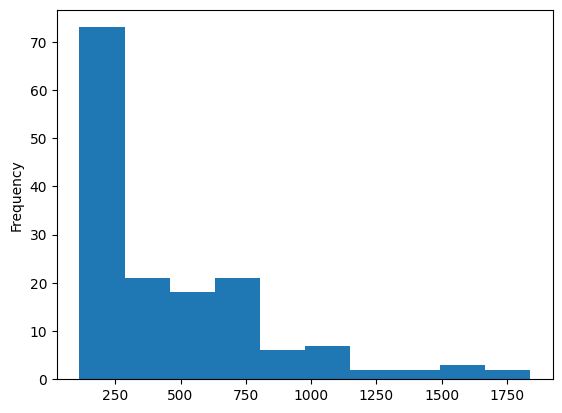

In [6]:
# Distribution

df['zinc'].plot(kind='hist')

In [7]:
df['log-zinc'] = np.log(df['zinc'])

<Axes: ylabel='Frequency'>

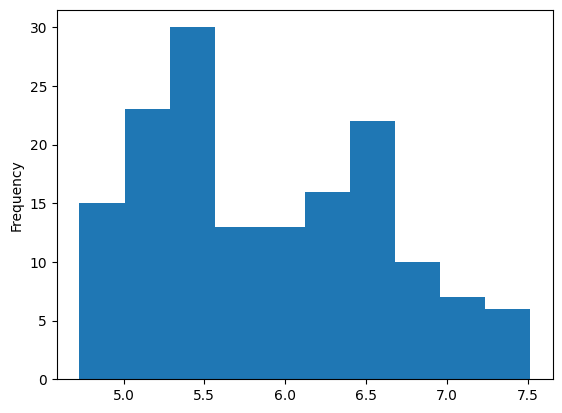

In [8]:
df['log-zinc'].plot(kind='hist')

The histogram is still not close to the normal distribution; it has two modes, but the tail is shorter. We will build models based on this histogram.

## 2. Create directional semivariograms

Data is prepared, we can model it's semivariance. We will perform an isotropic modeling and a full directional modeling in N-S, W-E, NE-SW, and NW-SE axes.

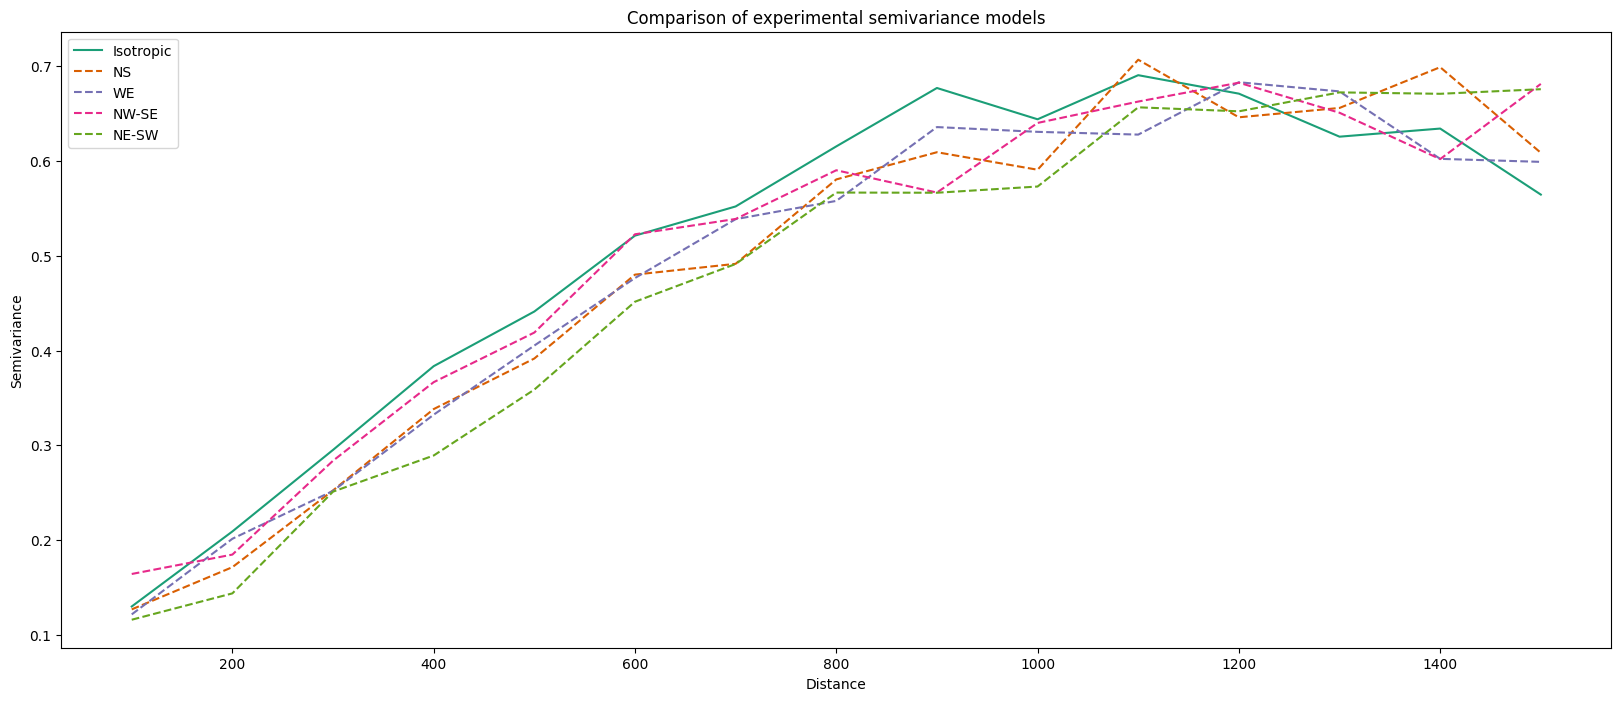

In [48]:
dirvar = DirectionalVariogram(ds=df[['x', 'y', 'log-zinc']],
                              step_size=STEP_SIZE,
                              max_range=MAX_RANGE,
                              tolerance=0.5,
                              dir_neighbors_selection_method='e')
dirvar.show()

We have five experimental variograms for further modeling. Let's build theoretical models from those.

In [49]:
MODEL_NAME = 'spherical'
DIRECTIONS = ['ISO', 'NS', 'WE', 'NE-SW', 'NW-SE']

In [50]:
theoretical_models = {}
variograms = dirvar.get()

for direction in DIRECTIONS:
    theoretical_model = TheoreticalVariogram()
    theoretical_model.autofit(experimental_variogram=variograms[direction],
                              models_group=MODEL_NAME,
                              nugget=0)
    theoretical_models[direction] = theoretical_model

## 3. Interpolate with directional Kriging

With a set of directional variograms we will perform spatial interpolation over a defined grid.

In [51]:
grid = pd.read_csv(MEUSE_GRID_FILE, usecols=['x', 'y'])
grid.head()

,x,y
0,181180,333740
1,181140,333700
2,181180,333700
3,181220,333700
4,181100,333660


In [52]:
kriged_results = {}

for direction in DIRECTIONS:
    result = interpolate_points(
        theoretical_model=theoretical_models[direction],
        known_locations=df[['x', 'y', 'log-zinc']].to_numpy(),
        unknown_locations=grid.to_numpy(),
        no_neighbors=16,
        max_tick=30,
        use_all_neighbors_in_range=False
    )
    result = pd.DataFrame(result, columns=['pred', 'err', 'x', 'y'])
    rgeometry = gpd.points_from_xy(result['x'], result['y'])
    rgeometry.name = 'geometry'
    result = gpd.GeoDataFrame(result, geometry=rgeometry)

    kriged_results[direction] = result

100%|██████████| 3103/3103 [00:01<00:00, 2028.91it/s]


In [53]:
kriged_results['ISO'].head()

,pred,err,x,y,geometry
0,6.614562,0.270738,181180.0,333740.0,POINT (181180 333740)
1,6.717101,0.187153,181140.0,333700.0,POINT (181140 333700)
2,6.594676,0.212485,181180.0,333700.0,POINT (181180 333700)
3,6.471774,0.239660,181220.0,333700.0,POINT (181220 333700)
4,6.838043,0.100923,181100.0,333660.0,POINT (181100 333660)


With all models calculated, we can compare the results of interpolation. We will show interpolation and variance errors across the models.

## 4. Compare models

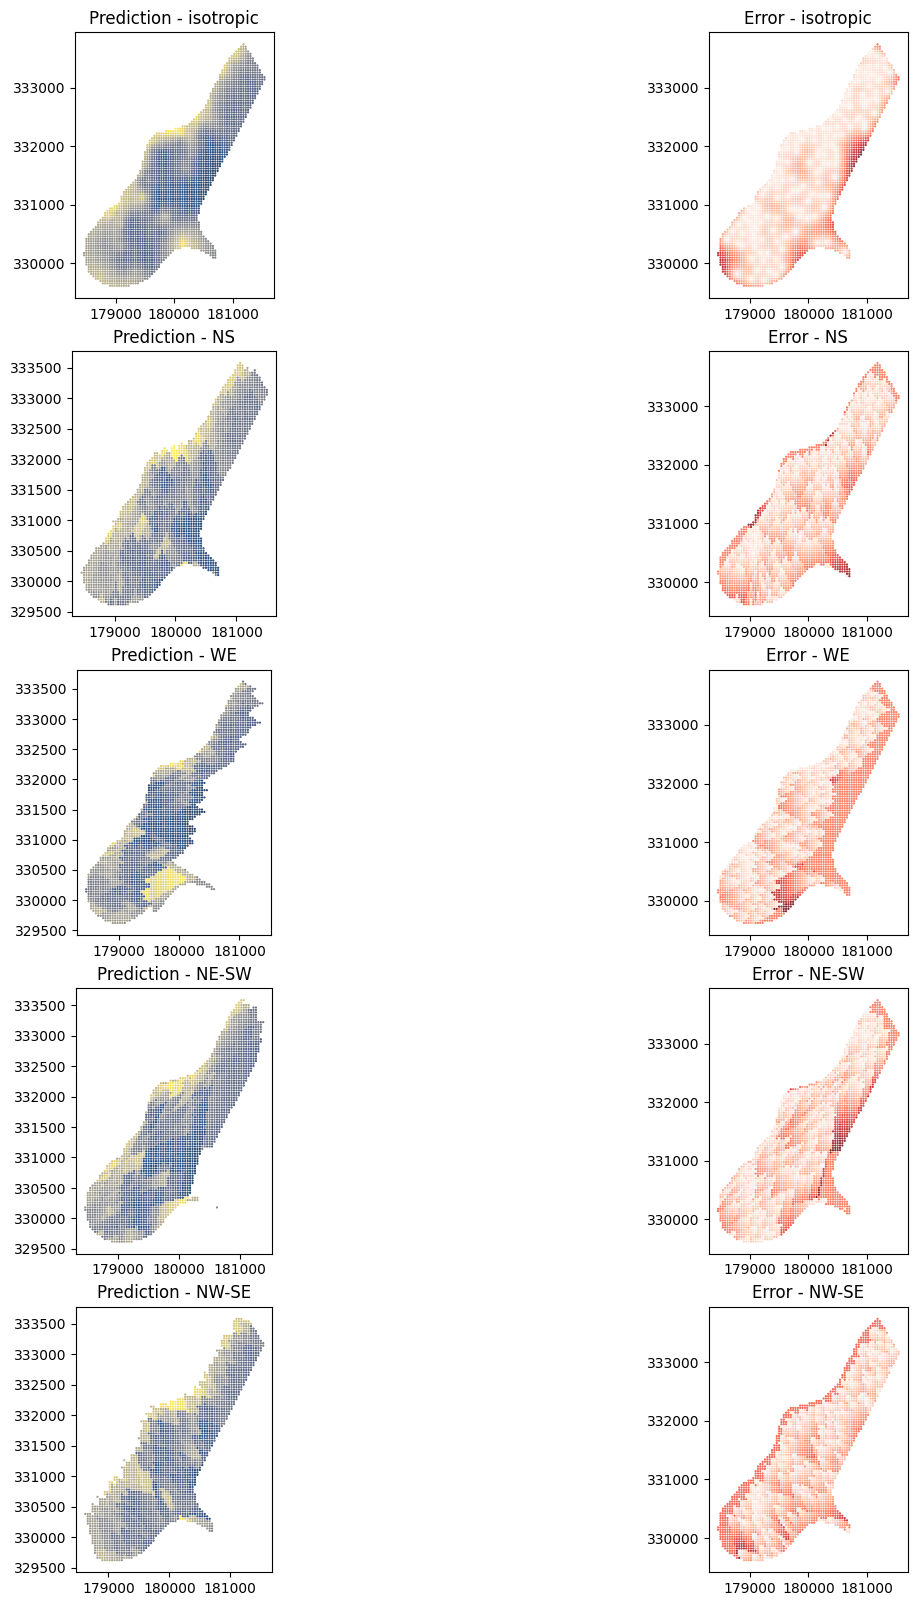

In [54]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

kriged_results['ISO'].plot(ax=ax[0, 0], column='pred', cmap='cividis', s=0.25)
kriged_results['ISO'].plot(ax=ax[0, 1], column='err', cmap='Reds', s=0.25)
ax[0, 0].set_title('Prediction - isotropic')
ax[0, 1].set_title('Error - isotropic')

kriged_results['NS'].plot(ax=ax[1, 0], column='pred', cmap='cividis', s=0.25)
kriged_results['NS'].plot(ax=ax[1, 1], column='err', cmap='Reds', s=0.25)
ax[1, 0].set_title('Prediction - NS')
ax[1, 1].set_title('Error - NS')

kriged_results['WE'].plot(ax=ax[2, 0], column='pred', cmap='cividis', s=0.25)
kriged_results['WE'].plot(ax=ax[2, 1], column='err', cmap='Reds', s=0.25)
ax[2, 0].set_title('Prediction - WE')
ax[2, 1].set_title('Error - WE')

kriged_results['NE-SW'].plot(ax=ax[3, 0], column='pred', cmap='cividis', s=0.25)
kriged_results['NE-SW'].plot(ax=ax[3, 1], column='err', cmap='Reds', s=0.25)
ax[3, 0].set_title('Prediction - NE-SW')
ax[3, 1].set_title('Error - NE-SW')

kriged_results['NW-SE'].plot(ax=ax[4, 0], column='pred', cmap='cividis', s=0.25)
kriged_results['NW-SE'].plot(ax=ax[4, 1], column='err', cmap='Reds', s=0.25)
ax[4, 0].set_title('Prediction - NW-SE')
ax[4, 1].set_title('Error - NW-SE')

plt.show()

Directional Kriging clearly shows the leading direction and is even more pronounced in the variance error maps. At the end, let's compare the mean of directional interpolations to the isotropic interpolation result:

In [55]:
mean_directional_results = (kriged_results['NS']['pred'] +
                            kriged_results['WE']['pred'] +
                            kriged_results['NE-SW']['pred'] +
                            kriged_results['NW-SE']['pred']) / 4

In [56]:
kriged_results['ISO']['mean_dir_pred'] = mean_directional_results

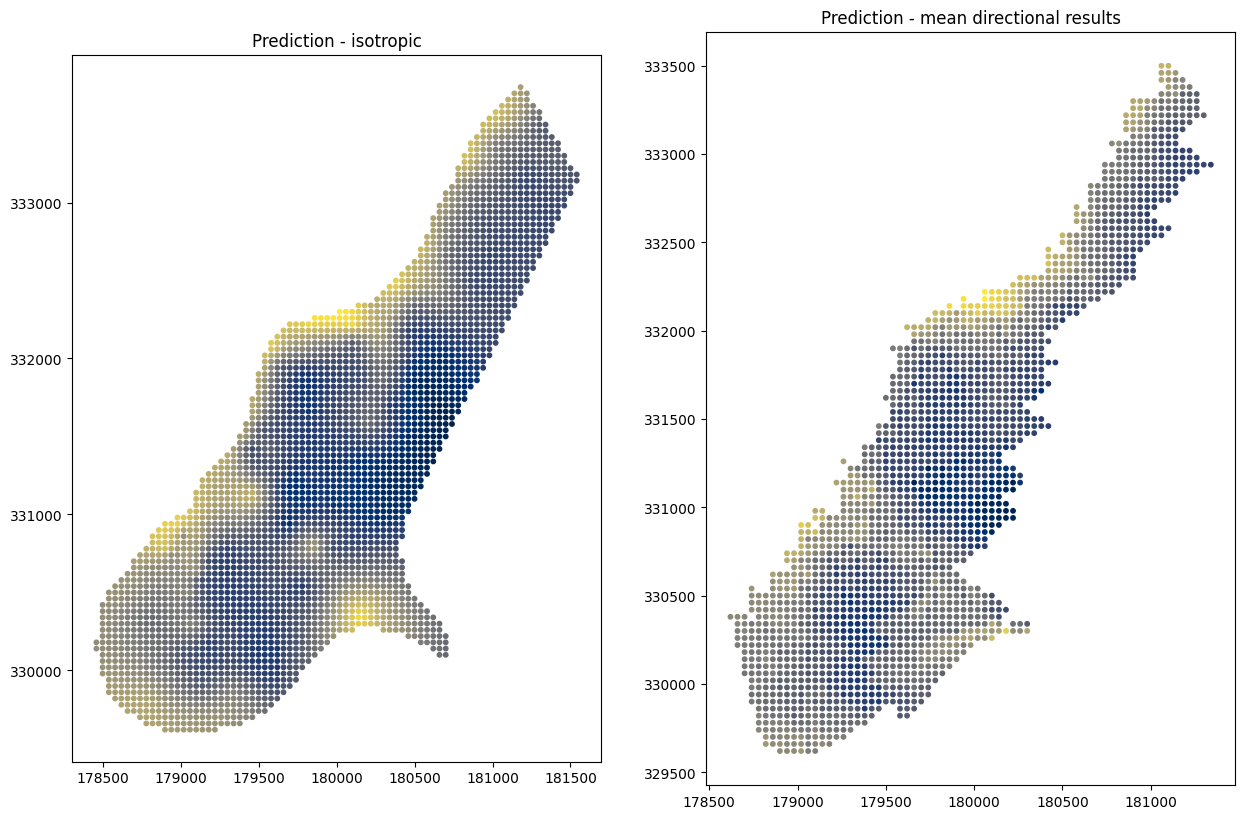

In [60]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 20))

kriged_results['ISO'].plot(ax=ax[0], column='pred', cmap='cividis', s=10)
ax[0].set_title('Prediction - isotropic')
kriged_results['ISO'].plot(ax=ax[1], column='mean_dir_pred', cmap='cividis', s=10)
ax[1].set_title('Prediction - mean directional results')
plt.show()

## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-05-17 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |